# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Данные для обучения - набор фотографий людей с указанием возраста, взяты с сайта ChaLearn Looking at People. Они находятся в папке '/datasets/faces/'.
Набор данных состоит из одной папки со всеми изображениями (/final_files) и CSV-файла 'labels.csv' с двумя колонками: 'file_name' и 'real_age'.

Метрикой качества является MAE, необходимо добиться значения MAE на тестовой выборке не больше 8.

## Исследовательский анализ данных

Импортируем нужные для анализа библиотеки

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

Проведём первичный анализ датафрейма

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

labels.info()
labels.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


В датафрейме две колонки - название файла с фотографией и возраст человека на ней. Пропусков не обнаружено

Загружаем данные из датафрейма и указываем путь к объектам для загрузчика

In [3]:
datagen = ImageDataGenerator(rescale=1./255)
files = '/datasets/faces/final_files/'

train_datagen = datagen.flow_from_dataframe(dataframe=labels,
                                            directory=files,
                                            x_col='file_name',
                                            y_col='real_age',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='raw',
                                            seed=113)

Found 7591 validated image filenames.


Посмотрим на распределение объектов по целевому признаку

Размер выборки - 7591 объект


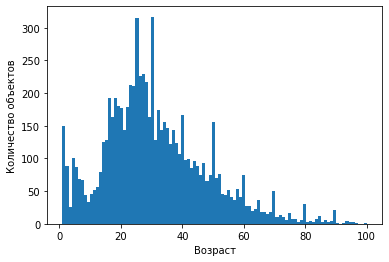

In [4]:
print(f'Размер выборки - {labels.shape[0]} объект')
plt.hist(labels['real_age'], bins=100)
plt.xlabel('Возраст')
plt.ylabel('Количество объектов')
plt.show()

Целевой признак - возраст покупателя, для него такое распределение близко к нормальному, и для наших задач оно подойдёт.

Совсем маленьким детям продукты обычно покупают родители, объектов для того чтобы отличить подростка которому алкоголь продавать нельзя от взрослого котороуму можно - достаточно, а всех покупателей старше определённого возраста (например шестидесяти лет) можно объединить в категорию "пожилые люди", потому что у них интересы схожи.

Выведем первые пятнадцать фотографий

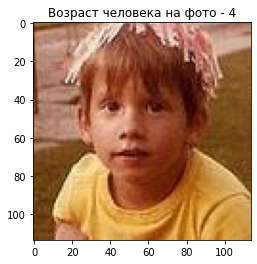

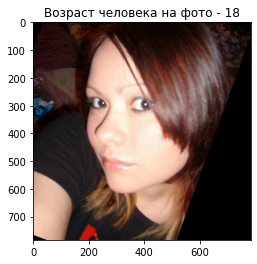

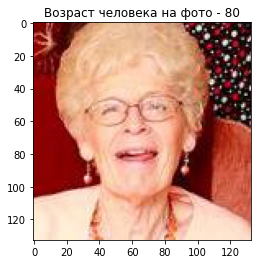

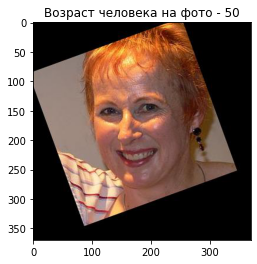

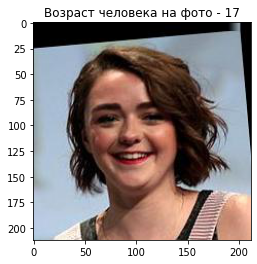

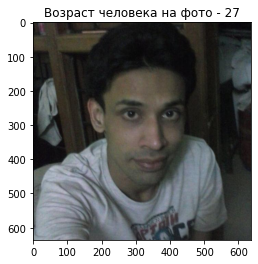

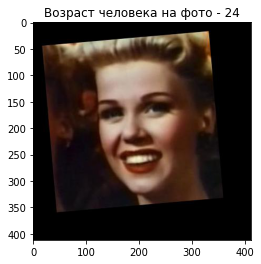

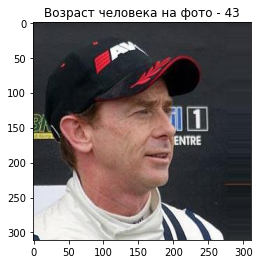

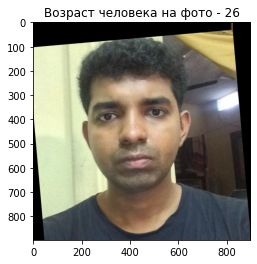

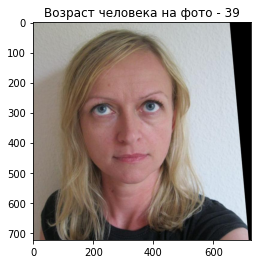

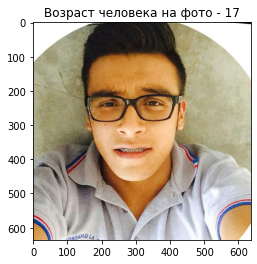

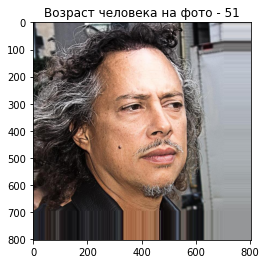

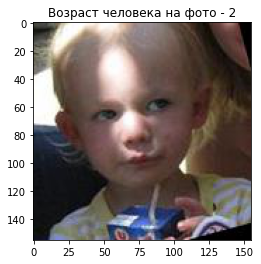

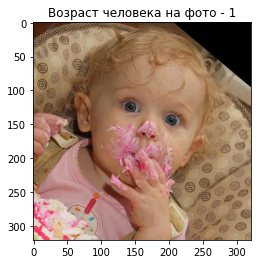

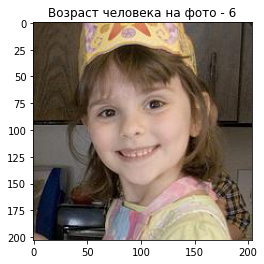

In [5]:
for i in range(15):
    age = labels['real_age']
    if i < 10:
        file = ('/datasets/faces/final_files/00000{}.jpg').format(i)
        image = Image.open(file)
        array = np.array(image)
        plt.imshow(array)
        plt.title(f'Возраст человека на фото - {age[i]}')
        plt.show()
    else:
        file = ('/datasets/faces/final_files/0000{}.jpg').format(i)
        image = Image.open(file)
        array = np.array(image)
        plt.imshow(array)
        plt.title(f'Возраст человека на фото - {age[i]}')
        plt.show()

Данные готовы, перейдём к обучению

## Обучение модели

Обучение выполнялось на GPU сервере, ниже представлен код и результат вывода

('/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5' - это 'imagenet', предзагруженные на сервер)

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

labels = pd.read_csv('/datasets/faces/labels.csv')
files = '/datasets/faces/final_files/'

train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255., vertical_flip=True,
                                   horizontal_flip=True, height_shift_range=.2, width_shift_range=.2)

train_data = train_datagen.flow_from_dataframe(dataframe=labels,
                                               directory=files,
                                               x_col='file_name',
                                               y_col='real_age',
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='raw',
                                               subset='training',
                                               seed=113)

test_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255.)

test_data = test_datagen.flow_from_dataframe(dataframe=labels,
                                             directory=files,
                                             x_col='file_name',
                                             y_col='real_age',
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='raw',
                                             subset='validation',
                                             seed=113)

backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
optimizer = Adam(0.00001)

model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(units=1, activation='relu'))
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

model.fit(train_data, 
          validation_data=test_data,
          epochs=13,
          verbose=2)

```

```
Found 6073 validated image filenames.
Found 1518 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 190 steps, validate for 48 steps
Epoch 1/15
190/190 - 113s - loss: 937.7591 - mae: 25.8015 - val_loss: 1145.4586 - val_mae: 29.3182
Epoch 2/15
190/190 - 103s - loss: 259.7405 - mae: 12.3973 - val_loss: 1145.4586 - val_mae: 29.3182
Epoch 3/15
190/190 - 106s - loss: 154.1805 - mae: 9.1949 - val_loss: 908.5553 - val_mae: 25.3717
Epoch 4/15
190/190 - 103s - loss: 121.1757 - mae: 8.2541 - val_loss: 170.5984 - val_mae: 9.8433
Epoch 5/15
190/190 - 96s - loss: 102.3567 - mae: 7.6598 - val_loss: 106.2154 - val_mae: 7.8878
Epoch 6/15
190/190 - 95s - loss: 93.5387 - mae: 7.2968 - val_loss: 95.2812 - val_mae: 7.3249
Epoch 7/15
190/190 - 94s - loss: 83.7444 - mae: 6.9515 - val_loss: 105.8359 - val_mae: 7.7559
Epoch 8/15
190/190 - 95s - loss: 78.0351 - mae: 6.7838 - val_loss: 93.0694 - val_mae: 7.2881
Epoch 9/15
190/190 - 97s - loss: 72.7971 - mae: 6.5192 - val_loss: 92.5784 - val_mae: 7.2462
Epoch 10/15
190/190 - 99s - loss: 68.3156 - mae: 6.3371 - val_loss: 87.6438 - val_mae: 7.0759
Epoch 11/15
190/190 - 99s - loss: 63.5699 - mae: 6.1363 - val_loss: 89.8445 - val_mae: 7.1567
Epoch 12/15
190/190 - 101s - loss: 60.5549 - mae: 5.9753 - val_loss: 84.7588 - val_mae: 6.9980
Epoch 13/15
190/190 - 101s - loss: 57.0048 - mae: 5.8206 - val_loss: 91.7407 - val_mae: 7.1596
Epoch 14/15
190/190 - 100s - loss: 55.2516 - mae: 5.7337 - val_loss: 92.7402 - val_mae: 7.2988
Epoch 15/15
190/190 - 99s - loss: 51.2158 - mae: 5.5257 - val_loss: 86.1015 - val_mae: 6.9220

48/48 - 9s - loss: 86.1015 - mae: 6.9220
Test MAE: 6.9220
```

## Анализ обученной модели

Нам удалось достичь значения MAE в 6.922, неплохой результат, учитывая, что даже люди не всегда могут понять сколько другому человеку лет по его внешнему виду.

Модель достаточно быстро обучилась - две минуты на первый слой и по полторы на следующие. Для того, чтобы сделать предсказания точнее, можно попробовать увеличить выборку, но нужно учесть, что в этом случае и обучение займёт больше времени. Также можно провести тесты этой модели но с задачей классификации, чтобы понять, насколько хорошо она разделяет возрастные группы, и при необходимости увеличить категорию, с которой есть проблемы, этот же тест подскажет, как хорошо модель отделяет подростков от взрослых.

Обученная модель будет достаточно точно определять возрастную категорию покупателя и может помочь как в рекомендации товаров, которые могут его заинтересовать, так и в контроле за незаконной продажей алкоголя.